In [2]:
import pandas as pd
import numpy as np
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from Clean import Clean
import time
import copy

def prep_data():

    print("prepping data...")

    df = pd.read_csv('./data/FM_2000-2019.csv')
    print(df.shape)
    df_all = df[df['gp_all_0_a'] >= 30]
    df = df_all[0:-100]
    df_test = df_all[-100:]
    print(df.shape)

    games = 30
    q = 1

    clean = Clean(df,games)
    features = clean.get_features(['e-def-rating','e-off-rating','e-pace'],q)
    y = clean.get_target(q).values
    x = features.values

    return features,x,y

def build_prior_model(prior,features,x,y):

    cols = features.columns

    print('building model with prior:', prior)
    prior_model = pm.Model()

    for i in range(len(cols)):
        print(i,cols[i])

    with prior_model:

        # Priors for unknown model parameters
        alpha = pm.Normal('alpha', mu=0, sigma=10)

        if prior == 'normal':
            beta_def = pm.Normal('beta_def', mu=-.25, sigma=.25, shape=8)
            beta_off = pm.Normal('beta_off', mu=.25, sigma=.25, shape=8)
            beta_pace = pm.Normal('beta_pace', mu=.25, sigma=.25, shape=8)

        if prior == 'uniform':
            beta_def = pm.Uniform('beta_def', upper = 0, lower = -.5, shape=8)
            beta_off = pm.Uniform('beta_off', upper = .5, lower = 0, shape=8)
            beta_pace =pm.Uniform('beta_pace', upper = .5, lower = 0, shape=8)

        if prior == 'truncnormal':
            beta_def = pm.TruncatedNormal('beta_def', mu = -.25 , sigma=.25, upper = 0 , shape=8)
            beta_off = pm.TruncatedNormal('beta_off', mu = .25 , sigma=.25, lower = 0 , shape=8)
            beta_pace = pm.TruncatedNormal('beta_pace', mu = .25 , sigma=.25, lower = 0 , shape=8)



        sigma = pm.HalfNormal('sigma', sigma=1)

        # Expected value of outcome
        mu = alpha
        for i in ['off','def','pace']:

            if i == 'off':

                off_col_list = [j*3 for j in range(8)]
                x = features.iloc[:,off_col_list].values
                mu += pm.math.dot(x,beta_off)

            elif i == 'def':

                def_col_list = [j*3 + 1 for j in range(8)]
                x = features.iloc[:,def_col_list].values
                mu += pm.math.dot(x,beta_def)

            elif i == 'pace':

                pace_col_list = [j*3 + 2 for j in range(8)]
                x = features.iloc[:,pace_col_list].values
                mu += pm.math.dot(x,beta_pace)

        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)

    return prior_model,off_col_list,def_col_list,pace_col_list

In [3]:
features,x,y = prep_data()

prepping data...
(24171, 459)
(14392, 459)


In [28]:
model,off_col_list,def_col_lst,pace_col_list = build_prior_model('normal',features,x,y)

building model with prior: normal
0 e-off-rating_all_0_a
1 e-def-rating_all_0_a
2 e-pace_all_0_a
3 e-off-rating_court_0_a
4 e-def-rating_court_0_a
5 e-pace_court_0_a
6 e-off-rating_all_1_a
7 e-def-rating_all_1_a
8 e-pace_all_1_a
9 e-off-rating_court_1_a
10 e-def-rating_court_1_a
11 e-pace_court_1_a
12 e-off-rating_all_0_h
13 e-def-rating_all_0_h
14 e-pace_all_0_h
15 e-off-rating_court_0_h
16 e-def-rating_court_0_h
17 e-pace_court_0_h
18 e-off-rating_all_1_h
19 e-def-rating_all_1_h
20 e-pace_all_1_h
21 e-off-rating_court_1_h
22 e-def-rating_court_1_h
23 e-pace_court_1_h


In [39]:
start = time.time()
with model:
    #step = pm.NUTS()
    step = pm.Slice()
    #step = pm.EllipticalSlice()
    trace = pm.sample(10000, step=step, chains=4, cores=1, tune=3000)
    # trace = pm.sample(chains=4, cores=4)
print(time.time() - start)

Sequential sampling (4 chains in 1 job)
CompoundStep
>Slice: [sigma]
>Slice: [beta_pace]
>Slice: [beta_off]
>Slice: [beta_def]
>Slice: [alpha]
100%|██████████| 13000/13000 [32:28<00:00,  6.67it/s]    
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


4118.080913066864


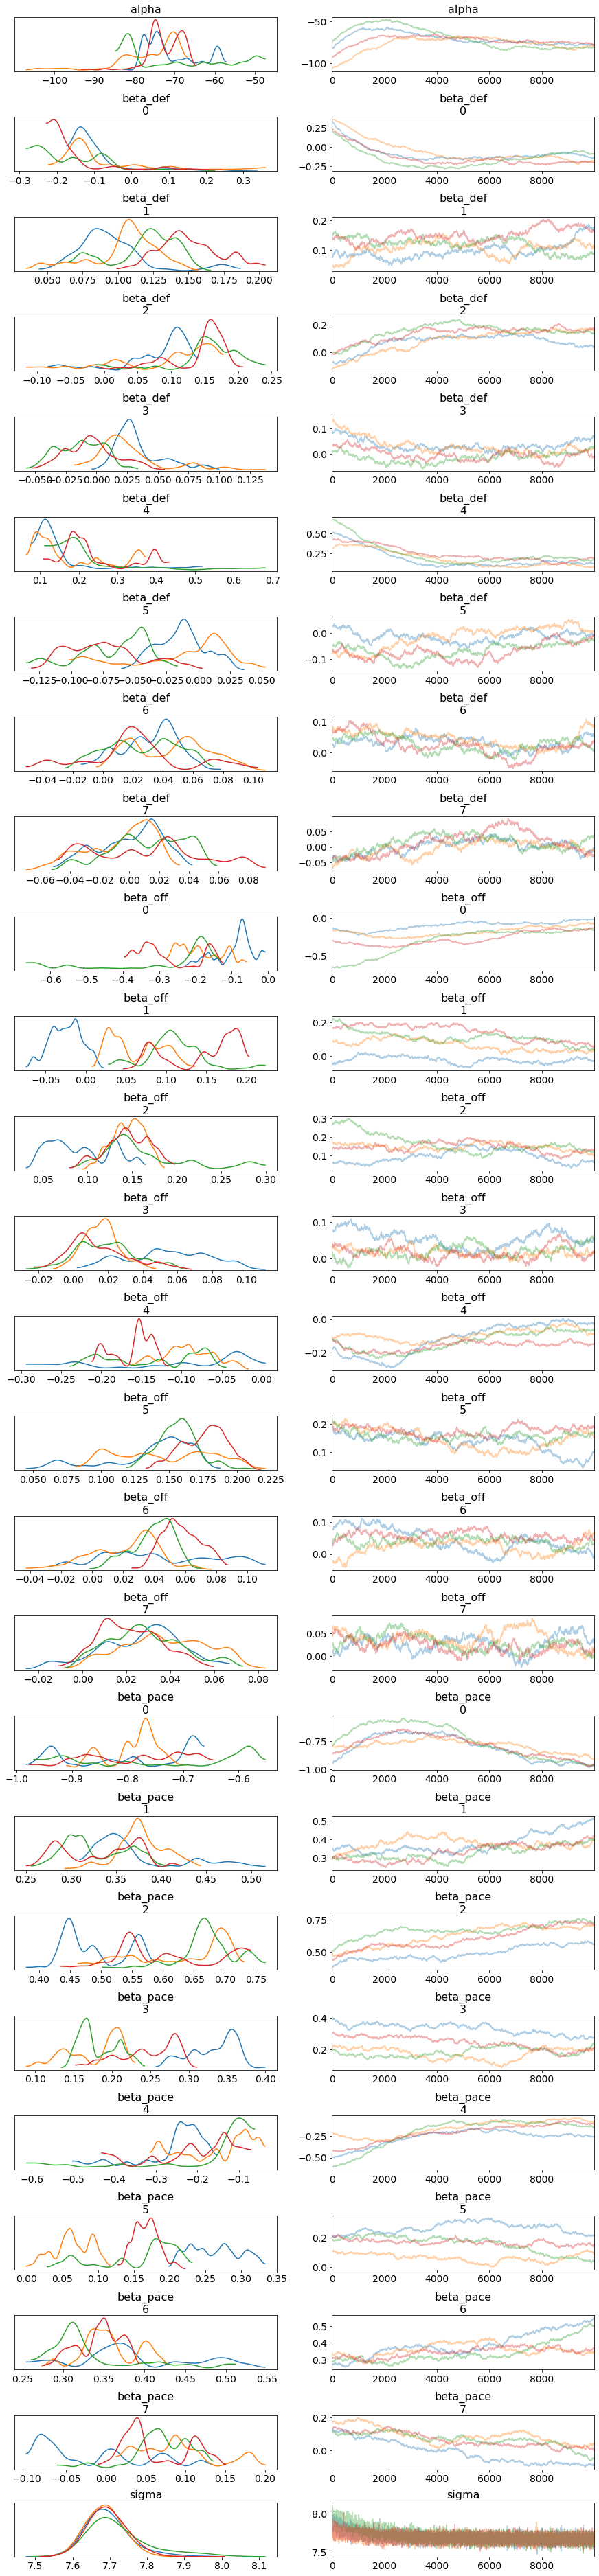

In [40]:
pm.traceplot(trace);

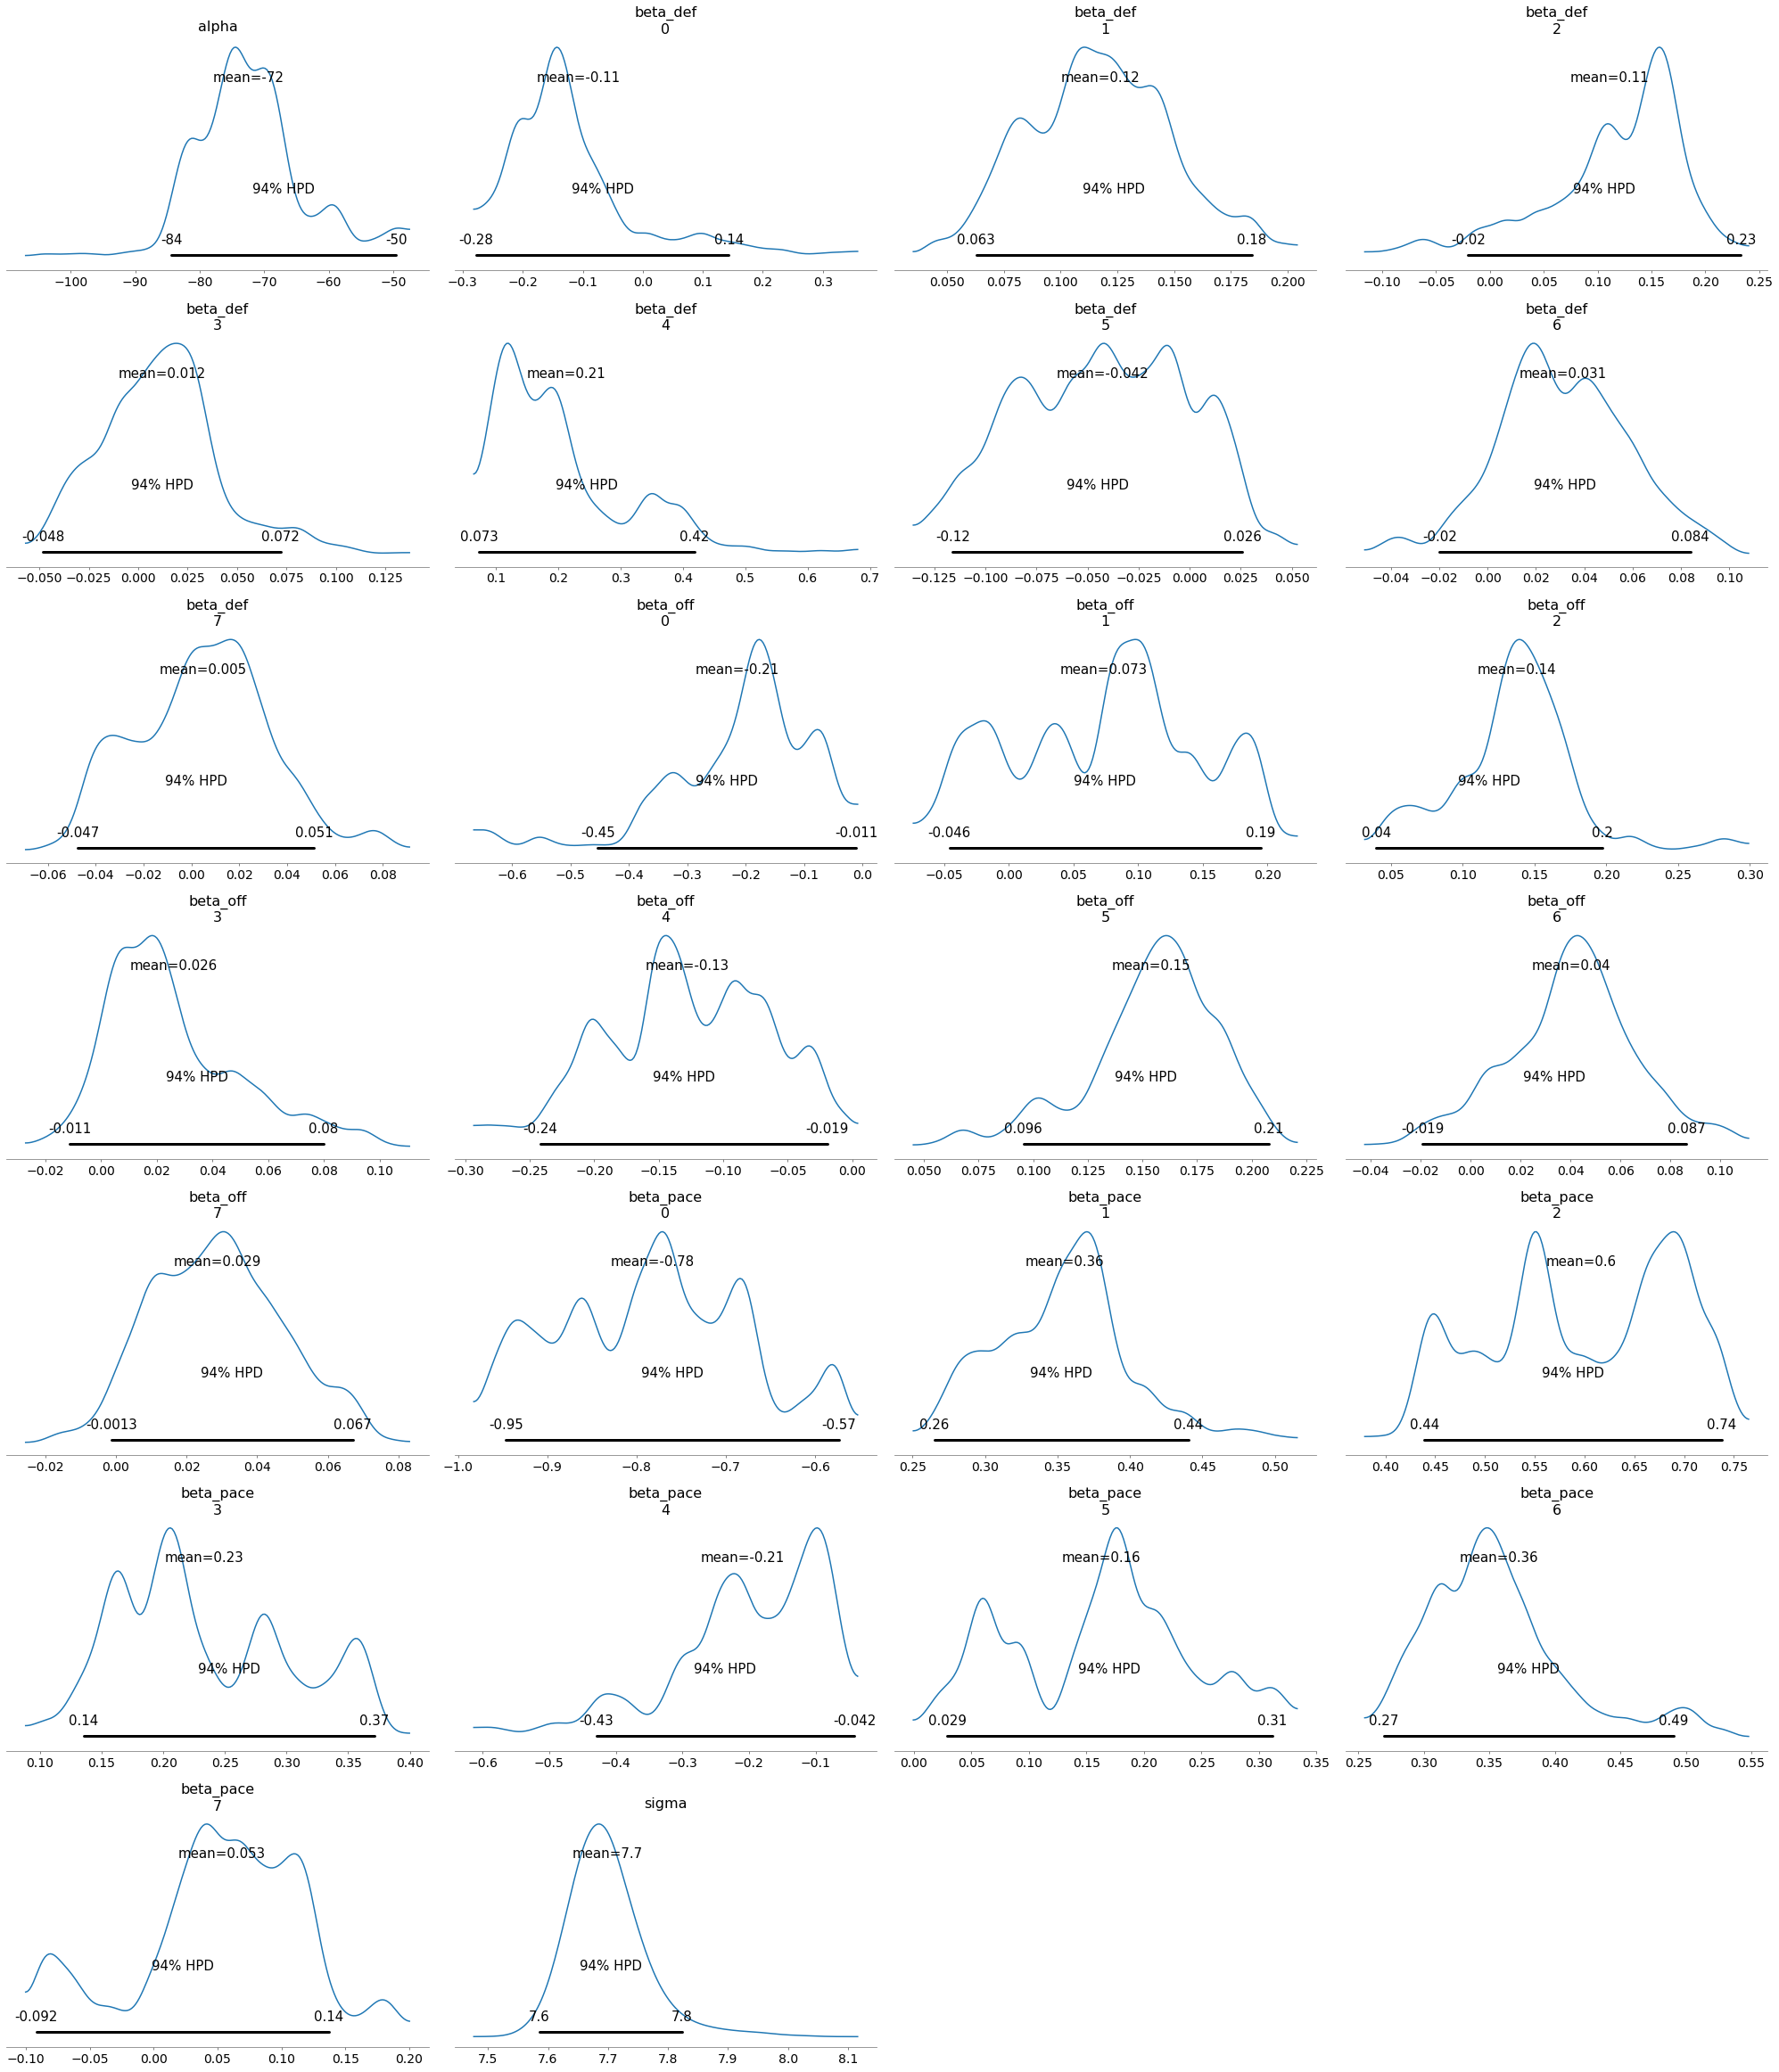

In [41]:
pm.plot_posterior(trace);

In [42]:
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=10000)

100%|██████████| 10000/10000 [00:20<00:00, 481.38it/s]


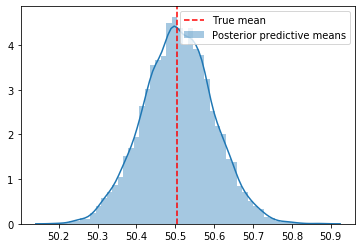

In [43]:
fig, ax = plt.subplots()
sns.distplot(ppc['Y_obs'].mean(axis=1), label='Posterior predictive means', ax=ax)
ax.axvline(y.mean(), ls='--', color='r', label='True mean')
ax.legend();

In [5]:
model_tn,off_col_list,def_col_lst,pace_col_list = build_prior_model('truncnormal',features,x,y)

building model with prior: truncnormal
0 e-off-rating_all_0_a
1 e-def-rating_all_0_a
2 e-pace_all_0_a
3 e-off-rating_court_0_a
4 e-def-rating_court_0_a
5 e-pace_court_0_a
6 e-off-rating_all_1_a
7 e-def-rating_all_1_a
8 e-pace_all_1_a
9 e-off-rating_court_1_a
10 e-def-rating_court_1_a
11 e-pace_court_1_a
12 e-off-rating_all_0_h
13 e-def-rating_all_0_h
14 e-pace_all_0_h
15 e-off-rating_court_0_h
16 e-def-rating_court_0_h
17 e-pace_court_0_h
18 e-off-rating_all_1_h
19 e-def-rating_all_1_h
20 e-pace_all_1_h
21 e-off-rating_court_1_h
22 e-def-rating_court_1_h
23 e-pace_court_1_h


In [6]:
start = time.time()
with model_tn:
    #step = pm.NUTS()
    #step = pm.Slice()
    step = pm.Metropolis()
    trace_tn = pm.sample(10000, step=step, chains=4, cores=1, tune=2000)
    # trace = pm.sample(chains=4, cores=4)
print(time.time() - start)

Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta_pace]
>Metropolis: [beta_off]
>Metropolis: [beta_def]
>Metropolis: [alpha]
100%|██████████| 12000/12000 [00:28<00:00, 428.53it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


119.42468571662903


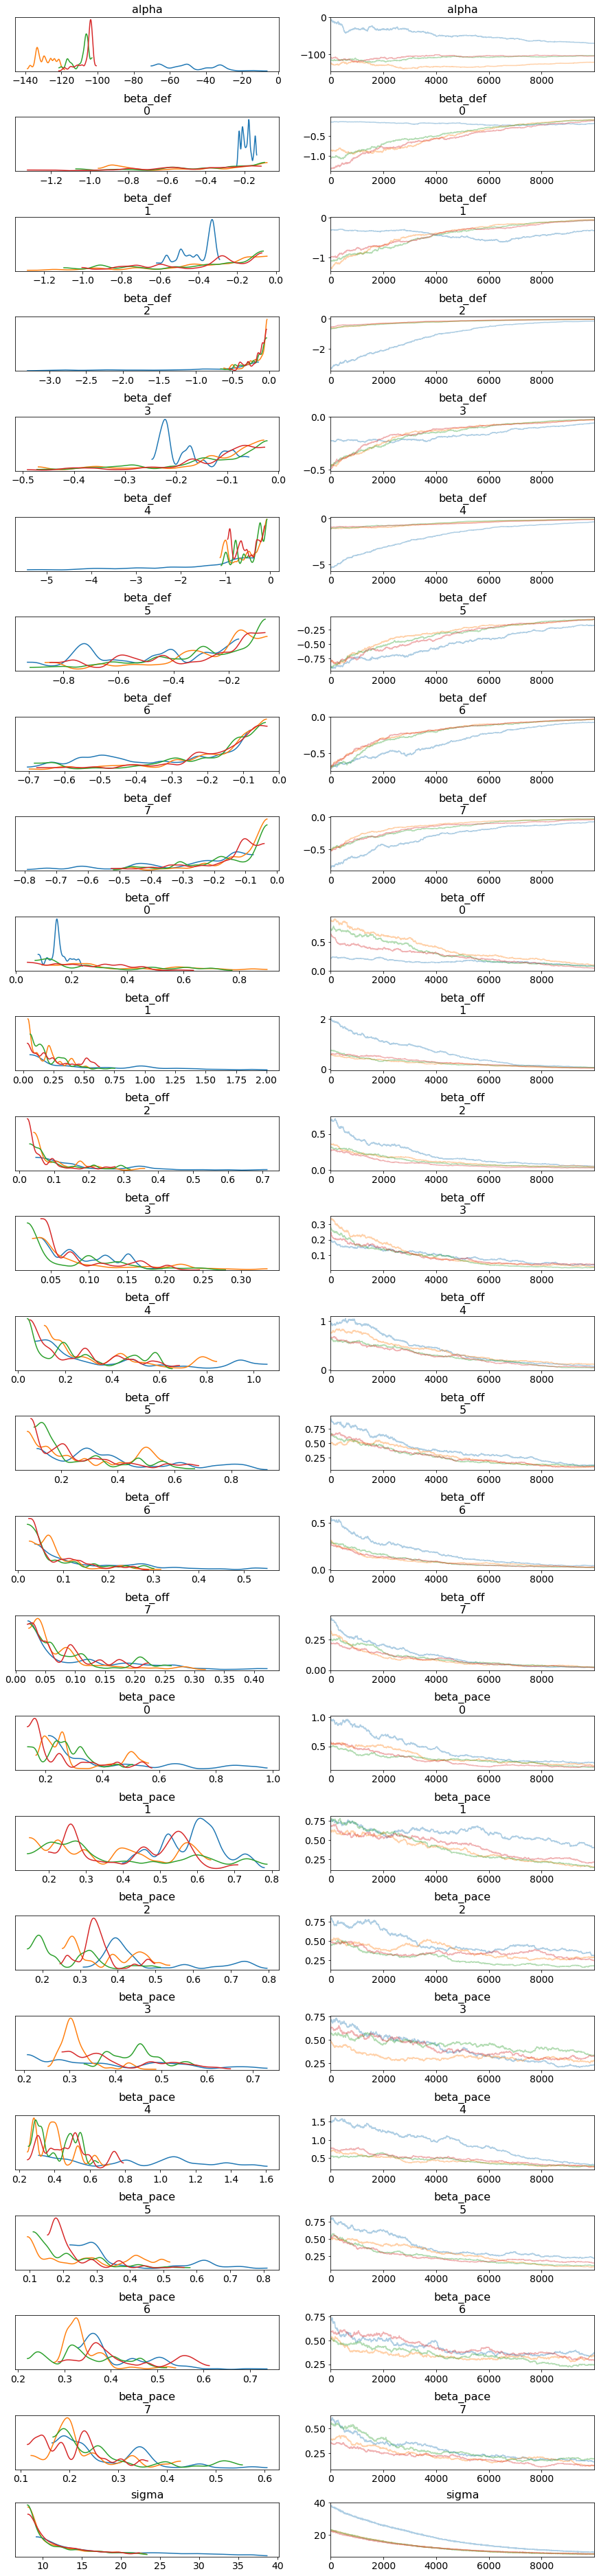

In [7]:
pm.traceplot(trace_tn);

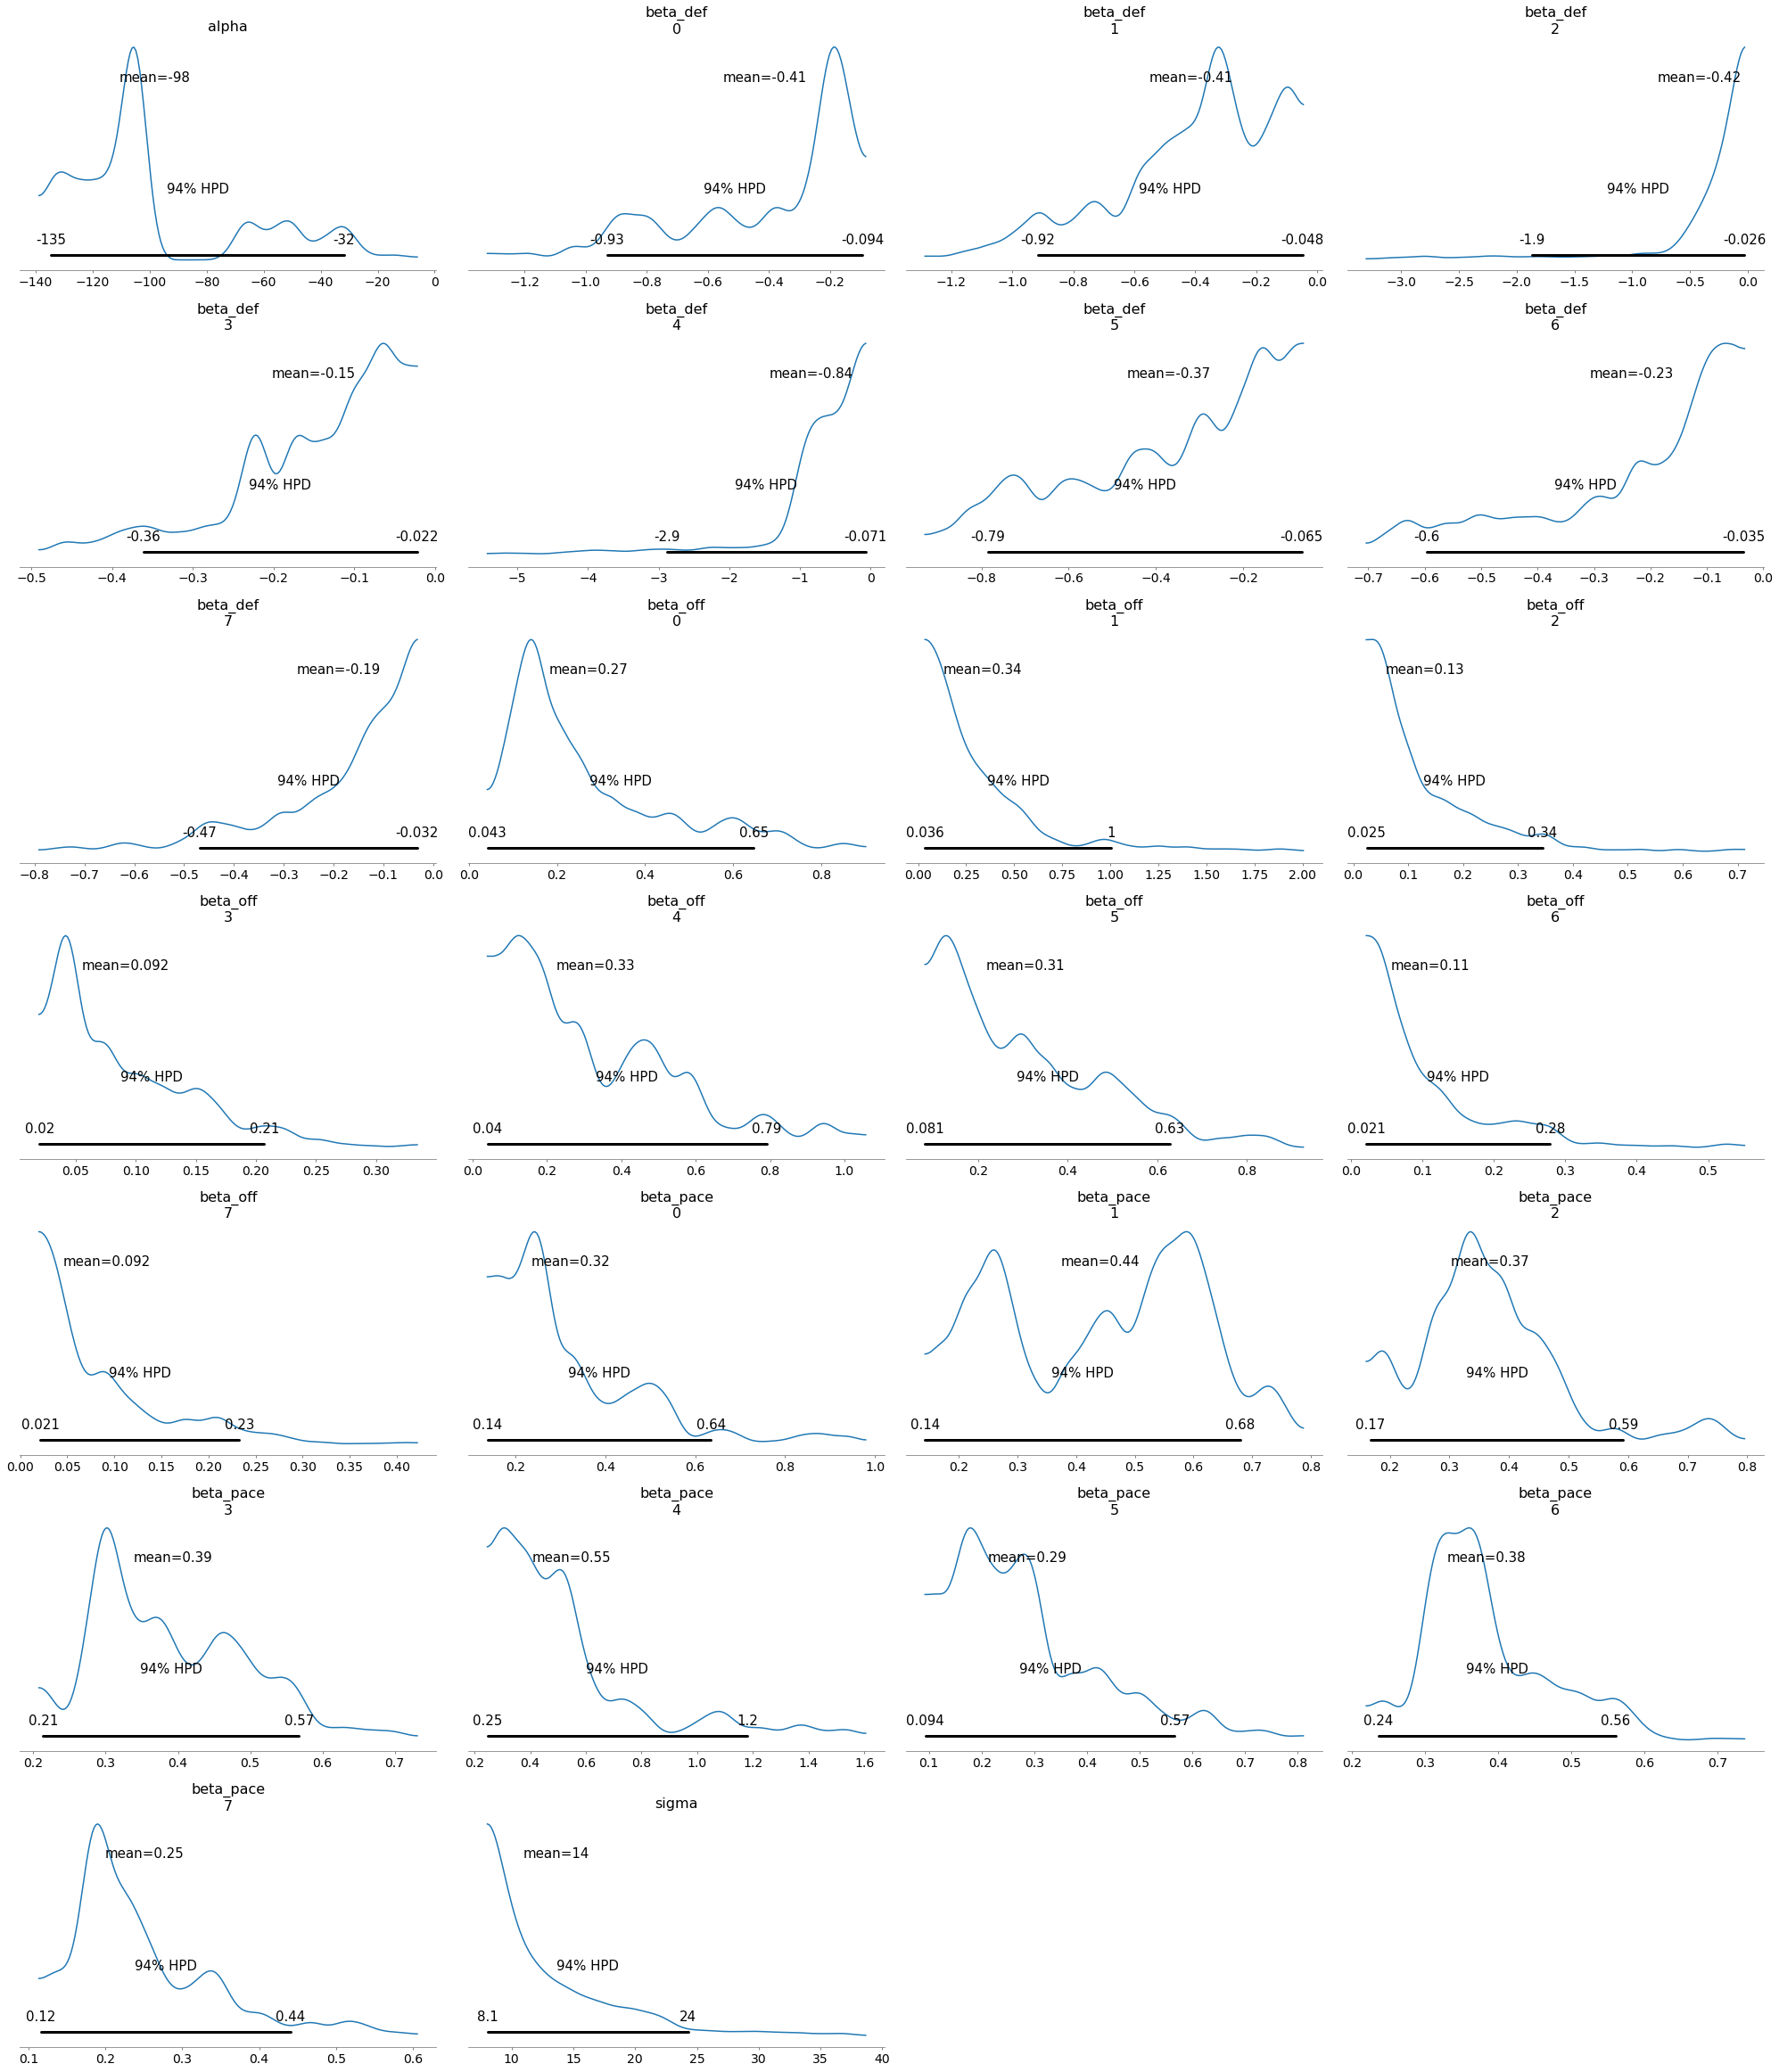

In [8]:
pm.plot_posterior(trace_tn);

In [9]:
with model_tn:
    ppc_tn = pm.sample_posterior_predictive(trace_tn, samples=10000)

100%|██████████| 10000/10000 [00:20<00:00, 485.44it/s]


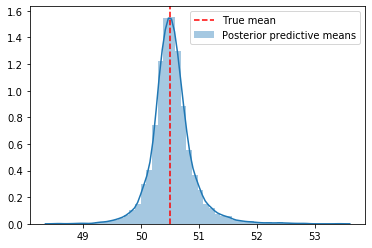

In [10]:
fig, ax = plt.subplots()
sns.distplot(ppc_tn['Y_obs'].mean(axis=1), label='Posterior predictive means', ax=ax)
ax.axvline(y.mean(), ls='--', color='r', label='True mean')
ax.legend();

In [11]:
model_uniform,off_col_list,def_col_lst,pace_col_list = build_prior_model('uniform',features,x,y)

building model with prior: uniform
0 e-off-rating_all_0_a
1 e-def-rating_all_0_a
2 e-pace_all_0_a
3 e-off-rating_court_0_a
4 e-def-rating_court_0_a
5 e-pace_court_0_a
6 e-off-rating_all_1_a
7 e-def-rating_all_1_a
8 e-pace_all_1_a
9 e-off-rating_court_1_a
10 e-def-rating_court_1_a
11 e-pace_court_1_a
12 e-off-rating_all_0_h
13 e-def-rating_all_0_h
14 e-pace_all_0_h
15 e-off-rating_court_0_h
16 e-def-rating_court_0_h
17 e-pace_court_0_h
18 e-off-rating_all_1_h
19 e-def-rating_all_1_h
20 e-pace_all_1_h
21 e-off-rating_court_1_h
22 e-def-rating_court_1_h
23 e-pace_court_1_h


In [12]:
start = time.time()
with model_uniform:
    #step = pm.NUTS()
    #step = pm.Slice()
    step = pm.Metropolis()
    trace_uniform = pm.sample(5000, step=step, chains=4, cores=1, tune=2000)
    # trace = pm.sample(chains=4, cores=4)
print(time.time() - start)

Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta_pace]
>Metropolis: [beta_off]
>Metropolis: [beta_def]
>Metropolis: [alpha]
100%|██████████| 7000/7000 [00:16<00:00, 418.05it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


71.27469277381897


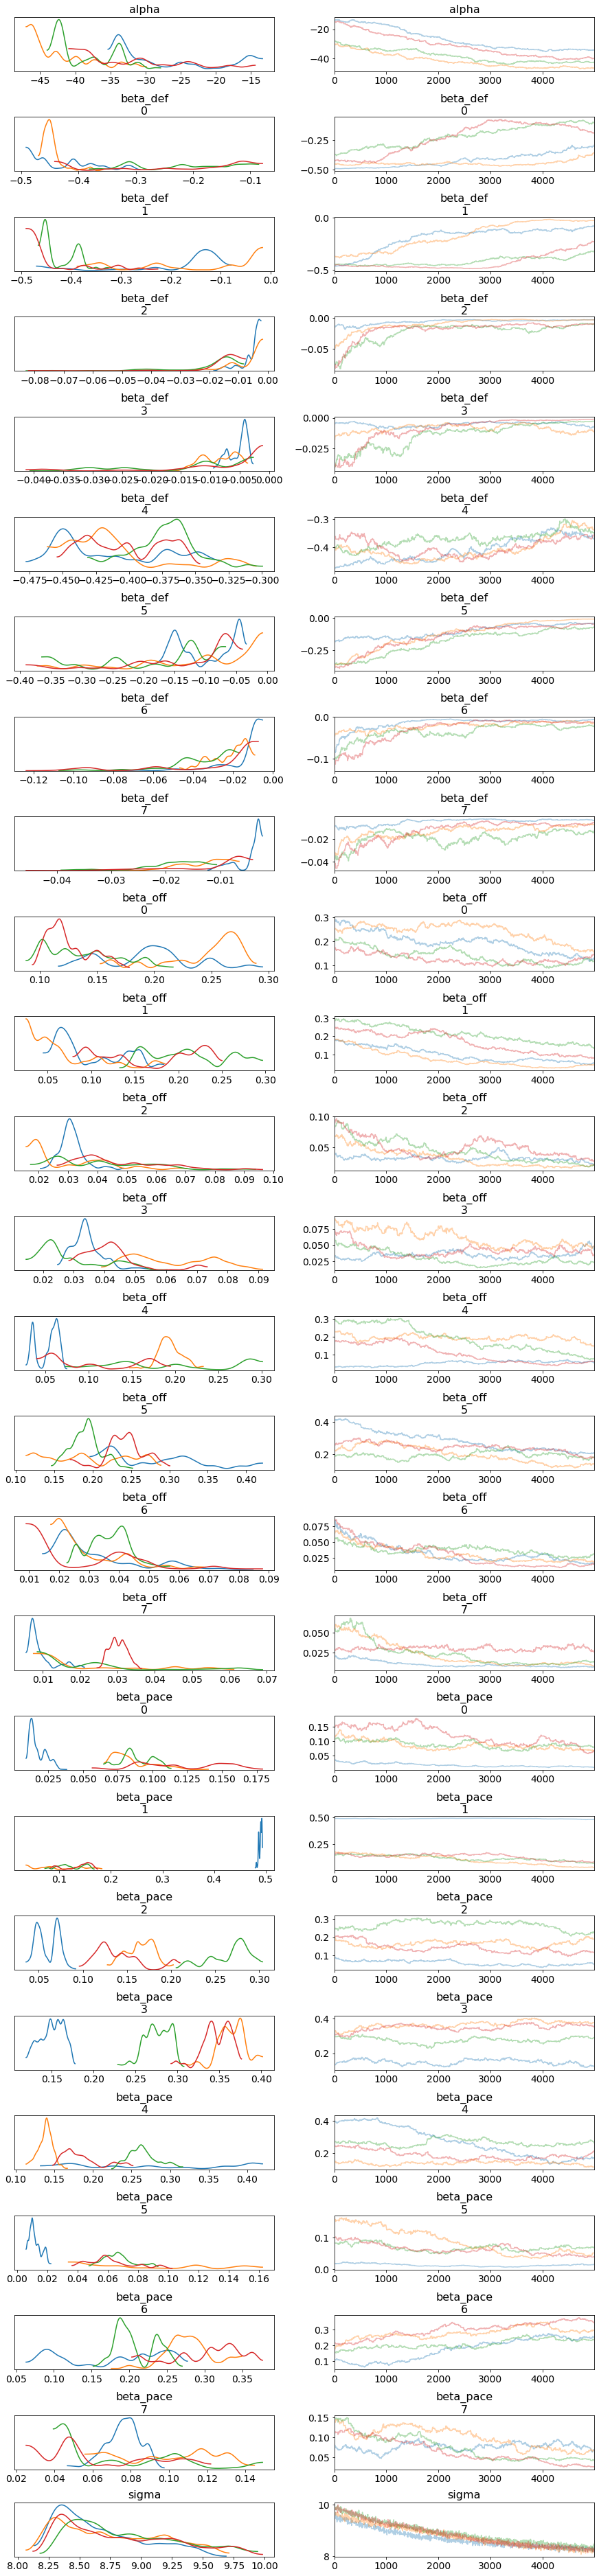

In [13]:
pm.traceplot(trace_uniform);

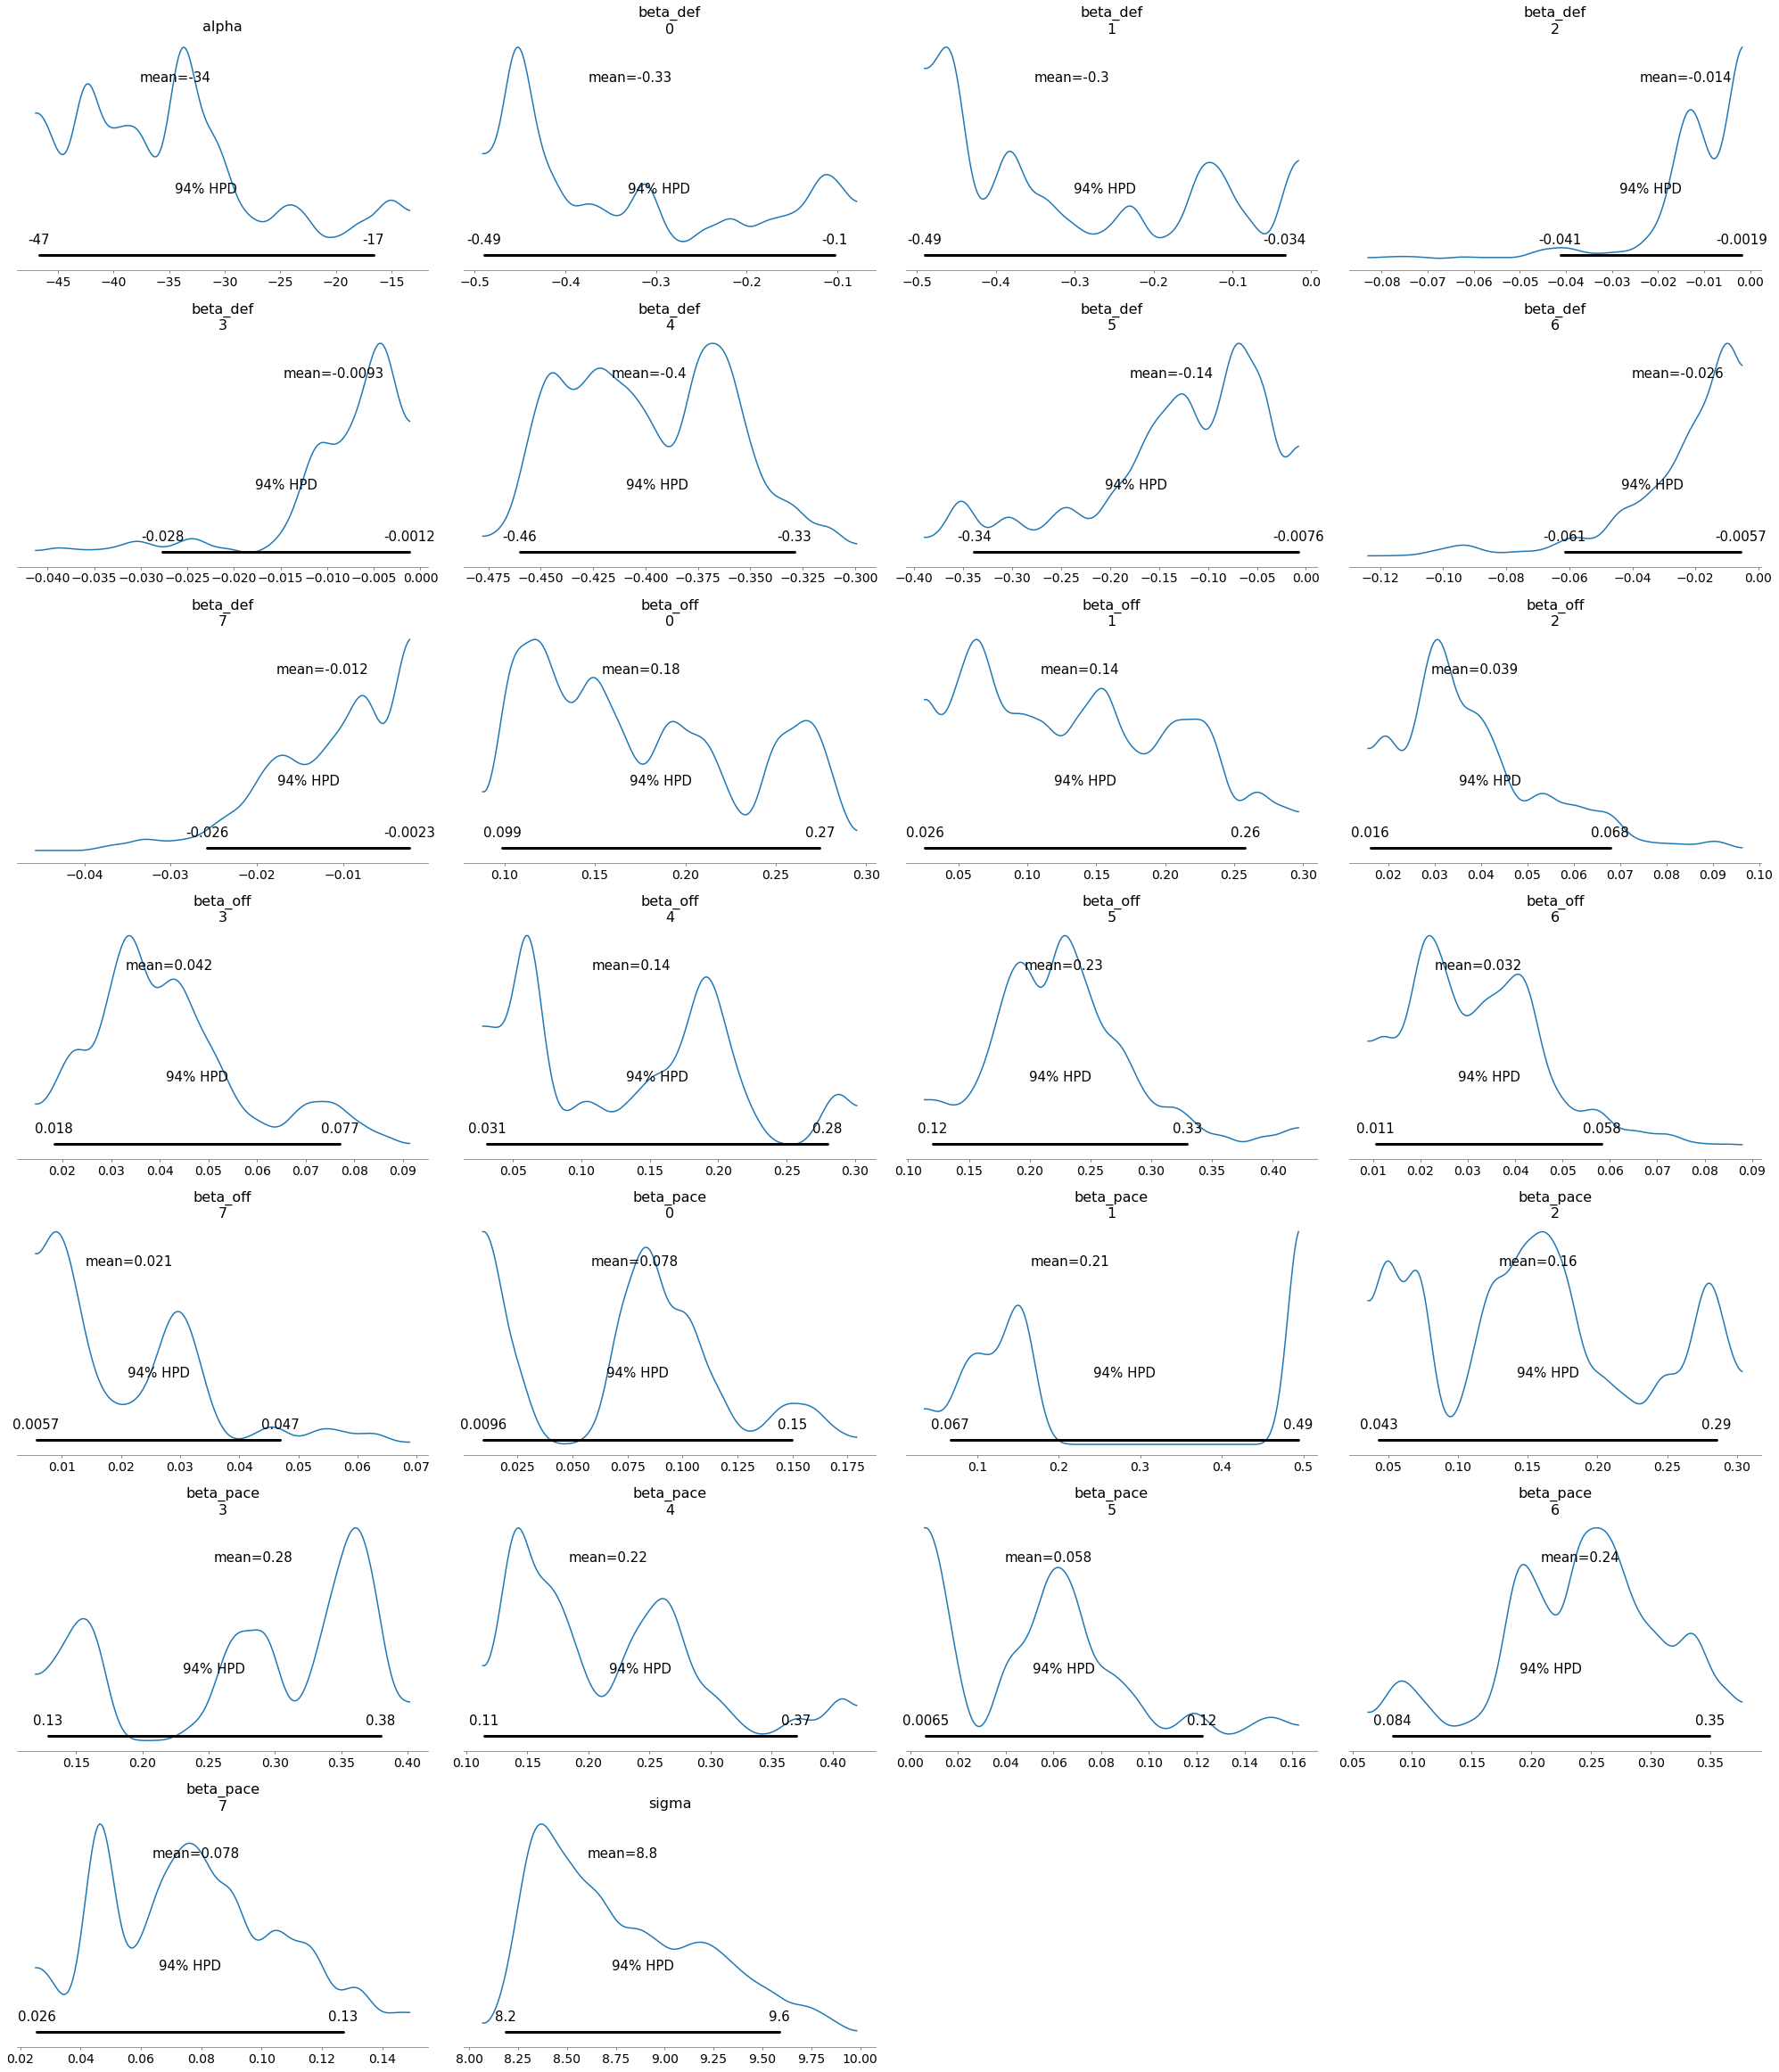

In [14]:
pm.plot_posterior(trace_uniform);

In [17]:
with model_uniform:
    ppc_uniform = pm.sample_posterior_predictive(trace_uniform, samples=10000)

100%|██████████| 10000/10000 [00:21<00:00, 458.17it/s]


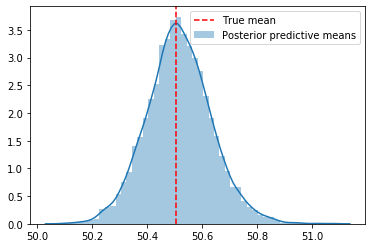

In [18]:
fig, ax = plt.subplots()
sns.distplot(ppc_uniform['Y_obs'].mean(axis=1), label='Posterior predictive means', ax=ax)
ax.axvline(y.mean(), ls='--', color='r', label='True mean')
ax.legend();